In [126]:
import gym
import minihack
import time
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tqdm import tqdm
import random
import math

# set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

from utils import *
from gen import test, random_search, true_random_search, true_random_nsteps


In [127]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                   -----------------                            
                     ----------    |...............|                            
                     |........|    |............|..|                            
                     |........|    |............|..|                            
                     ------...|    |..-----..----..|                            
                          |...|    |..|   |........|                            
                          |...|    |..|   |........|  ------                    
                    -------...------..|   |.....----  |....|                    
                    |.................|   |.....|     |....|                    
                    |..-----....|..|..|   |.....-------....|                    
                    |..|   

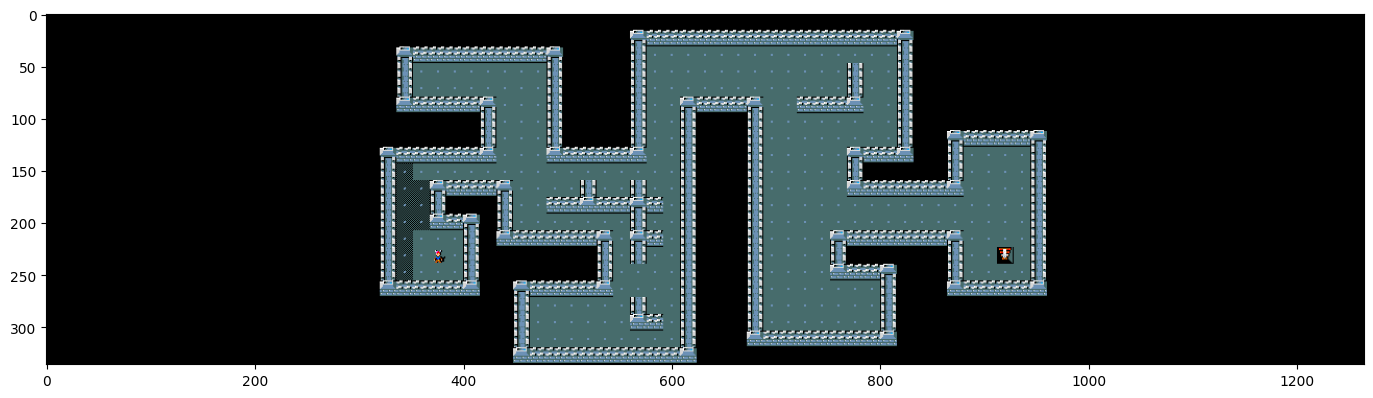

In [128]:
plt.imshow(state['pixel'])

In [129]:
a = (0, -1)
b = (0, 1)
c = (1, 0)      
d = (-1, 0)

ACTIONS = [a, b, c, d]


env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
    max_episode_steps=10000,
)

state = env.reset()
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)


def modify_action(t1, t2):
    """Sum two tuples"""
    return (t1[0] + t2[0], t1[1] + t2[1])

def is_crossoverable(action1, action2):
    # if action 1 and action 2 are oblique, return False
    dx = abs(action1[0] - action2[0])
    dy = abs(action1[1] - action2[1])
    # return false if the two components are changing together and > 1
    if (dx > 0 and dy > 0) and (dx > 1 or dy > 1):
        return False
    else:
        #print(f'actions: ,{action1, action2}')
        return True

def crossover_path(path1, path2):
    """Crossover two paths"""
    # randomly select a crossover point
    i = np.random.randint(1, min(len(path1), len(path2)))
    while not is_crossoverable(path1[i-1], path2[i]):
        i = np.random.randint(1, min(len(path1), len(path2)))

    # return the two paths joined at the crossover point
    # TODO:  implement controls on move validity

    # until the path is valid, merge the 2 path
    """print(f'point of crossover: {i}')
    print(f'path1: {path1}')
    print(f'path2: {path2}')
    print(f'lenp1: {len(path1[:i])}, path1[:i]: {path1[:i]}')
    print(f'lenp2: {len(path2[i:])}, path2[i:]: {path2[i:]}')"""

    pathtry = path1[:i] + path2[i:]

    #concatenete path1 and path2

    for idx in range(1, len(pathtry)):
        if is_wall(game_map[pathtry[idx]]):
            #truncate here pathtry[:idx]
            return path1[:i] + path2[i:idx-1]
    return pathtry

def crossover(actions1, actions2):
    """Crossover two paths"""
    # randomly select a crossover point
    i = np.random.randint(1, min(len(actions1), len(actions2)))
    # return the two paths joined at the crossover point
    return actions1[:i] + actions2[i:]

def mutate_path(path, mutation_rate=0.05):
    """Mutate a path"""
    # randomly select n postions to mutate
    print(f'before mutation {path}')
    actions = actions_from_path(start, path[1:])
    idxs = random.sample(list(range(len(actions)))[1:], k = math.floor(len(actions)/10))
    print("idxs", idxs)
    # randomly select new actions for each position and replace
    # TODO?  implement controls on move validity
    for idx in idxs:
        print(f"valid moves:", get_valid_actions(game_map, path[idx]))
        print(game_map[path[idx]])
        action = random.choice(get_valid_actions(game_map, path[idx]))
        actions[idx] = action
    path = path_from_actions(path[0], actions)
    print(f'after mutation {path}')
    return path

def mutate(actions, mutation_rate=0.05):
    """Mutate a path"""
    # randomly select n postions to mutate
    idxs = random.sample(list(range(len(actions))), k = math.floor(len(actions)/10))
    # randomly select new actions for each position and replace
    for idx in idxs:
        actions[idx] = random.choice([0, 1, 2, 3])
    return actions

In [130]:
MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 100

best_scores =[]
best_paths = []

print(f"> start: {start}, target: {target}")

fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [true_random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]
best_fitness = np.inf

print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS), postfix=f'best score: {best_fitness:.2f}'):
    
    generation_scores = []
    
    fitnesses = [fitness_function(individual) for individual in individuals]
    ind_actions = [actions_from_path(start, ind) for ind in individuals]
    generation_scores.append(min(fitnesses))

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))
    actions =  list(zip(ind_actions, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    actions.sort(key=lambda x:x[1])
    # sort ind_actions with respect to population
    
    #print(f"best score: {population[0][1]:.2f}")

    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.

    child1, child2, = actions[0][0], actions[1][0]

    offspring = [crossover(child1, child2) for _ in range(MAX_INDIVIDUALS)]
    offspring = [mutate(child) for child in offspring]
    ind_actions = offspring
    individuals = [path_from_actions(game_map, start, child) for child in offspring]

    best_fitness = population[0][1]
    best_scores.append(population[0][1])    
    best_paths.append(population[0][0])
    #print(f"Generation {generation}: best score {best_fitness:.2f}")

    if best_fitness == 0:
        break

    # update tqdm postfix
    tqdm._instances.clear()
    
# print best score and best path
best_idx = np.argmin(best_scores)
print(f"Best score: {best_scores[best_idx]:.2f}")
print(f"Best path: {best_paths[best_idx]}")
print(f"generation of best path: {best_idx}")

> start: (14, 23), target: (14, 57)
> Creating initial population...
> Evolving...


 15%|█▌        | 150/1000 [00:00<00:04, 173.57it/s, best score: inf]

Best score: 0.00
Best path: [(14, 22), (13, 22), (12, 22), (11, 22), (10, 22), (9, 22), (9, 23), (9, 24), (9, 23), (9, 22), (9, 23), (9, 24), (9, 25), (9, 24), (9, 25), (9, 26), (9, 27), (9, 28), (9, 29), (9, 28), (9, 27), (9, 28), (10, 28), (10, 28), (10, 28), (9, 28), (9, 29), (9, 30), (10, 30), (10, 31), (10, 31), (10, 30), (10, 31), (10, 30), (10, 31), (10, 30), (9, 30), (9, 31), (9, 32), (9, 33), (9, 32), (9, 33), (9, 34), (9, 35), (9, 36), (8, 36), (7, 36), (7, 36), (6, 36), (7, 36), (7, 37), (7, 36), (7, 37), (7, 37), (7, 37), (7, 37), (7, 37), (6, 37), (6, 36), (5, 36), (5, 37), (4, 37), (4, 38), (4, 39), (4, 40), (4, 41), (4, 42), (4, 43), (5, 43), (5, 44), (6, 44), (7, 44), (7, 43), (7, 44), (7, 45), (7, 46), (7, 47), (8, 47), (8, 47), (9, 47), (9, 47), (10, 47), (11, 47), (11, 48), (11, 49), (11, 48), (11, 49), (11, 50), (11, 50), (11, 51), (11, 52), (11, 53), (12, 53), (12, 54), (12, 55), (13, 55), (13, 56), (13, 57), (14, 57), (15, 57), (14, 57)]
generation of best path: 1

In [131]:
for path in best_paths:
    for x, y in path:
        if is_wall(game_map[x,y]):
            raise ValueError("Path is invalid because it goes through a wall")

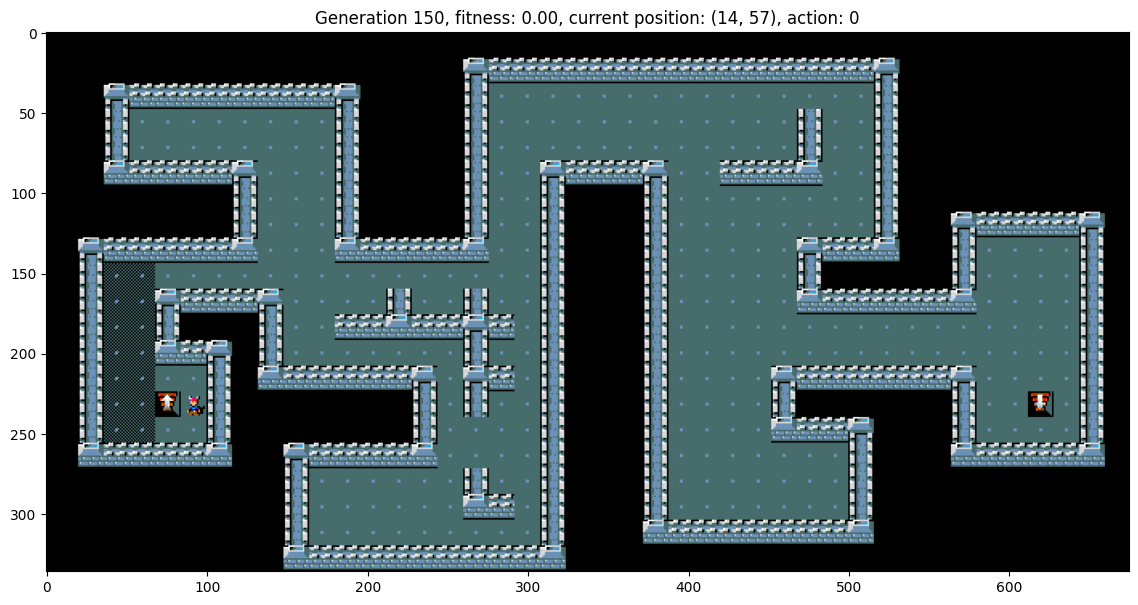

In [132]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
    max_episode_steps=10000,
)

state = env.reset()
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

plt.rcParams['figure.figsize'] = [17, 7]

image = plt.imshow(game[:, 300:975])
best_paths = best_paths[-1]
for i, p in enumerate(best_paths):
    if i == len(best_paths)-1:
        break
    if p == best_paths[i+1]:
        best_paths.pop(i+1)

# for generation, path in enumerate(best_paths):
# plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, last move: {path[-1]}")
start = best_paths[0]
path = best_paths[1:]
actions = actions_from_path(start, path)

for i, action in enumerate(actions):
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.title(f"Generation {generation}, fitness: {best_scores[generation]:.2f}, current position: {path[i]}, action: {action}")
    image.set_data(s['pixel'][:, 300:975])
    time.sleep(0.1)

In [25]:
best_paths

[(13, 23),
 (13, 22),
 (12, 22),
 (11, 22),
 (10, 22),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25),
 (9, 24),
 (9, 23),
 (9, 24),
 (9, 25),
 (9, 24),
 (9, 25),
 (9, 26),
 (9, 25),
 (9, 24),
 (9, 23),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25),
 (9, 26),
 (9, 27),
 (9, 28),
 (9, 29),
 (9, 30),
 (9, 31),
 (9, 32),
 (9, 33),
 (9, 34),
 (9, 35),
 (9, 36),
 (9, 37),
 (8, 37),
 (7, 37),
 (6, 37),
 (6, 37),
 (7, 37),
 (8, 37),
 (7, 37),
 (6, 37),
 (5, 37),
 (4, 37),
 (4, 38),
 (3, 38),
 (3, 37),
 (2, 37),
 (2, 38),
 (2, 39),
 (2, 40),
 (2, 41),
 (3, 41),
 (3, 42),
 (3, 43),
 (3, 44),
 (4, 44),
 (5, 44),
 (6, 44),
 (6, 45),
 (6, 46),
 (6, 47),
 (7, 47),
 (6, 47),
 (7, 47),
 (8, 47),
 (9, 47),
 (10, 47),
 (10, 47),
 (10, 46),
 (10, 47),
 (11, 47),
 (11, 48),
 (11, 47),
 (11, 48),
 (11, 49),
 (11, 50),
 (11, 51),
 (11, 52),
 (12, 52),
 (12, 53),
 (12, 54),
 (12, 55),
 (12, 56),
 (13, 56),
 (13, 57),
 (13, 58),
 (14, 58),
 (14, 57)]

In [24]:
get_player_location(game_map)

(10, 30)